# Tutorial: Overfitting/Underfitting and Bias/Variance

Tutorial to the class [Overfitting/Underfitting and Bias/Variance](3_overfitting_underfitting_bias_variance.ipynb) based on the same case study as in [Tutorial: Supervised Learning Problem and Least Squares](2_tutorial_supervised_learning_problem_ols.ipynb).

<div class="alert alert-block alert-info">
    <b>Tutorial Objectives</b>
    
- Evaluate model performance by estimating the Expected Prediction Errors (EPE) using test data
- Same as above but with cross-validation
- Compute and plot learning curves
- Improve the models by modifying the input features
</div>

## Getting ready

Let us follow the same procedure as in [Tutorial: Supervised Learning Problem and Least Squares](2_tutorial_supervised_learning_problem_ols.ipynb) to import the required modules and read the data.

In [12]:
# Path manipulation module
from pathlib import Path
# Numerical analysis module
import numpy as np
# Formatted numerical analysis module
import pandas as pd
# Plot module
import matplotlib.pyplot as plt

# Set data directory
data_dir = Path('data')

# Set keyword arguments for pd.read_csv
kwargs_read_csv = dict()

# Set first and last years
FIRST_YEAR = 2014
LAST_YEAR = 2019

# Define temperature filepath
temp_filename = 'surface_temperature_merra2_{}-{}.csv'.format(
    FIRST_YEAR, LAST_YEAR)
temp_filepath = Path(data_dir, temp_filename)

# Define electricity demand filepath
dem_filename = 'reseaux_energies_demand_demand.csv'
dem_filepath = Path(data_dir, dem_filename)

# Read hourly temperature and demand data averaged over each region
df_temp_hourly = pd.read_csv(temp_filepath, index_col=0, parse_dates=True, header=0)
df_dem_hourly = pd.read_csv(dem_filepath, index_col=0, header=0, parse_dates=True)

# Get daily-mean temperature and daily demand
df_temp = df_temp_hourly.resample('D').mean()
df_dem = df_dem_hourly.resample('D').sum()

# Select Île-de-France region
region_name = 'Île-de-France'
df_temp_idf = df_temp[region_name]
df_dem_idf = df_dem[region_name]

## Estimating the prediction error using a test set

> ***Question***
> - Estimate the prediction error (prediction $R^2$) from 1 year of test data for Île-de-France using the other years to train an OLS.
> - How does it compare to the train error estimated from the train data?
> - Is the prediction $R^2$ an estimate of the expected prediction error or of the prediction error conditioned on some train dataset?
> - Do you expect overfitting to have occurred?

[-11627.59439614] 521400.0230388691
0.7588388729382017
0.7349052453709646


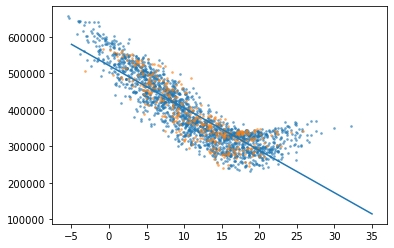

In [28]:
# Import
from sklearn import linear_model

# Prepare input and output for fit
X = df_temp_idf.values[:, None]
y = df_dem_idf.values

# Select test set from last year
X_test = X[-365:]
y_test = y[-365:]


# Select train set from previous years
X_train = X[:-365]
y_train = y[:-365]

# Fit model on train data
reg = linear_model.LinearRegression(fit_intercept=True)
reg.fit(X_train, y_train)
print(reg.coef_, reg.intercept_)
r2_train = reg.score(X_train, y_train)
print(r2_train)

r2_test = reg.score(X_test, y_test)
print(r2_test)

plt.scatter(X_train[:, 0], y_train, s=3, alpha=0.5)
plt.scatter(X_test[:, 0], y_test, s=3, alpha=0.5)
x = np.linspace(-5., 35., 100)
y_pred = reg.predict(x[:, None])
plt.plot(x, y_pred)

Answer:

> ***Question***
> - How does the prediction error changes if it is computed based on the last 3 months of the year instead?
> - Give at least 2 reasons to explain these changes.

In [ ]:
# Select test set from last 3 months
X_test = 
y_test = 

# Select train set from previous months
X_train = 
y_train = 

# Fit model on train data

# Predict from test inputs
y_pred = 

# Compute predict MSE and r2
mse_pred = 
r2_pred = 

Answer:

### Learning curve

> ***Question***
> - Compute and plot a learning curve. To do so:
>   - Set a year of data aside to compute the test error always on the same period
>   - Define a list of train period of increasing lengths
>   - Loop over these train periods to iteratively:
>     - Select data for this train period
>     - Train the model
>     - Compute the train error from the train data for the train period
>     - Compute the test error from the test data for the test period
>     - Save both errors
>   - Plot both errors curves
> - Interpret the results.

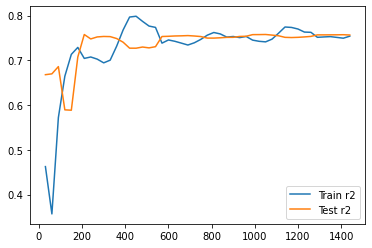

In [43]:
# Prepare input and output for fit
X = df_temp_idf.values[:, None]
y = df_dem_idf.values

# Select test set from last year
n_test = 365 * 2
X_test = X[-n_test:]
y_test = y[-n_test:]


# Select train set from previous years
X_train = X[:-n_test]
y_train = y[:-n_test]


# Define the number of days by which to increase the train periods
step = 30
n_days = np.arange(step, X_train.shape[0], step)

# Define arrays in which to save the errors
r2_trains = np.empty(n_days.shape)
r2_tests = np.empty(n_days.shape)

# Loop over train periods stopping before overlapping test period
for idx, nd in enumerate(n_days):
    # Select for the number of days
    X_train_nd = X_train[:nd]
    y_train_nd = y_train[:nd]
    
    # Fit
    reg = linear_model.LinearRegression(fit_intercept=True)
    reg.fit(X_train_nd, y_train_nd)
        
    # Get the train score
    r2_train = reg.score(X_train_nd, y_train_nd)
    
    # Get the test score
    r2_test = reg.score(X_test, y_test)
    
    r2_trains[idx] = r2_train
    r2_tests[idx] = r2_test
    
    
# Plot the learning curves
plt.plot(n_days, r2_trains, label='Train r2')
plt.plot(n_days, r2_tests, label='Test r2')
plt.legend()

In [37]:
list(enumerate(n_days))

[(0, 91),
 (1, 182),
 (2, 273),
 (3, 364),
 (4, 455),
 (5, 546),
 (6, 637),
 (7, 728),
 (8, 819),
 (9, 910),
 (10, 1001),
 (11, 1092),
 (12, 1183),
 (13, 1274),
 (14, 1365),
 (15, 1456),
 (16, 1547),
 (17, 1638),
 (18, 1729),
 (19, 1820)]

## Estimating the expected prediction error with cross-validation

> ***Question***
> - Perform a $k$-fold cross-validation of your own by repeating the above estimation of the test error on all years. To do so:
>   - Use the `split` method of a `sklearn.model_selection.KFold` object initialized with the `n_splits` option to get a sequence train and test indices over which to loop.
>   - For each pair of train and test indices:
>     - Select the train and test data from the input and output data;
>     - Fit the model using the train data;
>     - Use the fitted model to predict the target from the test inputs;
>     - Estimate the $R^2$ from the test output.
>   - Average the $R^2$ estimates.

In [11]:
# Import

# Number of splits

# Define k-fold iterator

# Loop over the train and test indices

# Select the train and test inputs

# Select the train and test outputs

# Fit the OLS model using the train data

# Predict the test output

# Compute R2

# Average R2 and print


> ***Question***
> - Verify your results using the `cross_val_score` function of `sklearn.model_selection` with the appropriate value for the `cv` option.
> - How does the $R^2$ estimate from the cross-validation compare to your estimation above?

In [50]:
# Import scikit-learn cross-validation function
from sklearn.model_selection import cross_val_score

r2_tests = cross_val_score(reg, X, y, cv=6)
r2_tests

array([0.73574491, 0.73122256, 0.781088  , 0.75698148, 0.7828644 ,
       0.72712148])

Answer: 

## Improving the linear model by adding features

We know from consumer behavior and heating technologies that individual heating tends to increase linearly from no heating below some heating temperature $T_H \approx 15$°C.

> ***Question***
> - Design two input variables that reflect this behavior.
> - Fit the two-dimensional linear model and plot its predictions.
> - Compute the train and test learning curves for this model.
> - Compare the results to the one-dimensional model and explain.

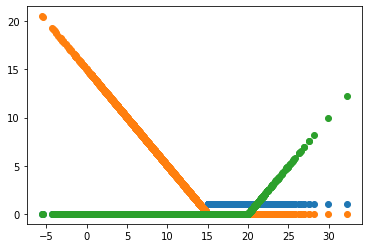

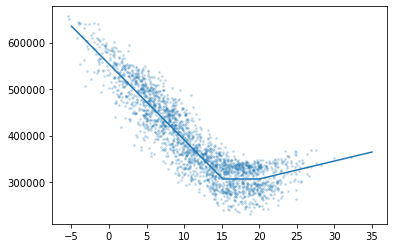

In [69]:
# Prepare input and output for fit
x = df_temp_idf.values
y = df_dem_idf.values

temp_heat = 15.
temp_cool = 20.

x_heat = (temp_heat - x) * (x < temp_heat).astype(float)
x_cool = (x - temp_cool) * (x > temp_cool).astype(float)
x_one = (x > temp_heat).astype(float)

plt.scatter(x, x_one)
plt.scatter(x, x_heat)
plt.scatter(x, x_cool)

X = np.empty((len(x_heat), 3))
X[:, 0] = x_one
X[:, 1] = x_heat
X[:, 2] = x_cool

reg = linear_model.LinearRegression()
reg.fit(X, y)

x0 = np.linspace(-5., 35., 100)
x_one0 = (x0 > temp_heat).astype(float)
x_heat0 = (temp_heat - x0) * (x0 < temp_heat).astype(float)
x_cool0 = (x0 - temp_cool) * (x0 > temp_cool).astype(float)
X0 = np.empty((len(x_heat0), 3))
X0[:, 0] = x_one0
X0[:, 1] = x_heat0
X0[:, 2] = x_cool0

y_pred = reg.predict(X0)

plt.figure()
plt.scatter(x, y, s=3, alpha=0.2)
plt.plot(x0, y_pred)

Answer:

In southern regions where climates are relatively warm, air conditioning may be used when daily-mean temperatures increase above about 20°C.
As a result, regional electricity demand increases somewhat linearly above this threshold.

> ***Question***
> - Add a third input variable to reflect this behavior apply and validate the model to the `'Provence-Alpes-Côte d'Azur'` region.
> - Compare the skills of the 1, 2 and 3-dimensional models.

In [ ]:
### Your answer


Answer: 

***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.
Several slides and images are taken from the very good [Scikit-learn course](https://inria.github.io/scikit-learn-mooc/).

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="images/logos/logo_lmd.jpg" style="display: inline-block"/>

<img alt="Logo IPSL" src="images/logos/logo_ipsl.png" style="display: inline-block"/>

<img alt="Logo E4C" src="images/logos/logo_e4c_final.png" style="display: inline-block"/>

<img alt="Logo EP" src="images/logos/logo_ep.png" style="display: inline-block"/>

<img alt="Logo SU" src="images/logos/logo_su.png" style="display: inline-block"/>

<img alt="Logo ENS" src="images/logos/logo_ens.jpg" style="display: inline-block"/>

<img alt="Logo CNRS" src="images/logos/logo_cnrs.png" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>